# Visualize datasets

This notebook is a quick introduction to the dataset we collected and some state of the art related to our HANet for handover. 

Our model of HANet is trained on trainin data of HANet (3a), and verified the accuracy of estimated grasp point by the datasets from state of the art and we collected.

||Datasets                 |amount|Object            |
|-|-------------------------|------|------------------------------------|
|1|Logistics: ConvNet [1]   |77    | products in 2017 Amazon robotic challenge  |       
|2|Pose estimation: DOPE [2]|92    | 21 objects in YCB object set  |
|3|HANet              | | |
|a|Training data      |1,080 |4 household objects and 9 object in YCB object set|
|b|Simple testing data| 200  |Same as Training data                             |
|c|Testing data       |  240 |10 objects in YCB object set, except the object in Training data|


## A. Import training datasets of HANet
creat a dataloader

In [1]:
# default_exp Datavisualizer

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
# export 
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset
import numpy as np


class handover_grasping_dataset(Dataset):
    """Dataloader.
    
    This Class is a dataloader for HANet.
    
    Args:
        data_dir(str) : Path include folders name 'color' and 'depth' and 'depth_npy'.
        mode(str) : Define this loader is for training or inference.
        color_type(str) : color image format.
        depth_type(str) : depth image format.
        
    Returns:
        A dict
    """
    name = []
    def __init__(self, data_dir, mode='train', color_type='jpg', depth_type='npy'):
        self.image_net_mean = np.array([0.485, 0.456, 0.406])
        self.image_net_std  = np.array([0.229, 0.224, 0.225])
        self.data_dir = data_dir
        self.mode = mode
        self.color_t = color_type
        self.depth_t = depth_type
        self.transform = transforms.Compose([
                        transforms.ToTensor(),
                    ])
        if self.mode == 'train':
            f = open(self.data_dir+"/train.txt", "r")
        else:
            f = open(self.data_dir+"/test.txt", "r")
        for _, line in enumerate(f):
              self.name.append(line.replace("\n", ""))

    def __len__(self):
        return len(self.name)
    def __getitem__(self, idx):
        idx_name = self.name[idx]
        if self.color_t == 'jpg':
            color_img = cv2.imread(self.data_dir+"/color/color_"+idx_name+'.jpg')
        else:
            color_img = cv2.imread(self.data_dir+"/color/color_"+idx_name+'.png')
        color_img = color_img[:,:,[2,1,0]]
        color_img = cv2.resize(color_img,(224,224))
        color_origin = cv2.resize(color_img,(640,480))
        if self.depth_t == 'npy':
            depth_img = np.load(self.data_dir+"/depth_npy/depth_"+idx_name+'.npy')
            depth_origin = np.load(self.data_dir+"/depth_npy/depth_"+idx_name+'.npy').astype(float)
        elif self.depth_t == 'png':
            depth_img = cv2.imread(self.data_dir+"/depth/depth_"+idx_name+'.png', -1)
            depth_origin = cv2.imread(self.data_dir+"/depth/depth_"+idx_name+'.png', -1).astype(float)
        elif self.depth_t == 'jpg':
            depth_img = cv2.imread(self.data_dir+"/depth/depth_"+idx_name+'.jpg', -1)
            depth_origin = cv2.imread(self.data_dir+"/depth/depth_"+idx_name+'.jpg', -1).astype(float)
        if self.depth_t != 'npy':
            if len(depth_img.shape) == 3:
                depth_img = depth_img[:,:,0]
                depth_origin = depth_origin[:,:,0]
            
        if depth_origin.shape[0] == 224:
            depth_origin = cv2.resize(depth_origin,(640,480))
            
        depth_img = cv2.resize(depth_img,(224,224))

        if self.mode == 'train':
            label_img = np.load(self.data_dir+"/label/label_"+idx_name+'.npy')

            f = open(self.data_dir+'/idx/id_'+idx_name+'.txt', "r")

            IDX = int(f.readlines()[0])

            # Unlabeled -> 2; unsuctionable -> 0; suctionable -> 1
            label_tmp = np.round(label_img[IDX]/255.*2.).astype(float)
            label = np.zeros((4,28,28))
            # Set label pixel
            label[IDX] = cv2.resize(label_tmp, (int(28), int(28)))
            label[IDX][label[IDX] != 0.0] = 1.0

            label_tensor = self.transform(label).float()

        # uint8 -> float
        color = (color_img/255.).astype(float)
        # BGR -> RGB and normalize
        color_rgb = np.zeros(color.shape)
        for i in range(3):
            color_rgb[:, :, i] = (color[:, :, 2-i]-self.image_net_mean[i])/self.image_net_std[i]

        depth_img = np.round((depth_img/np.max(depth_img))*255).astype('int').reshape(1,depth_img.shape[0],depth_img.shape[1])
        depth = (depth_img/1000.).astype(float) # to meters
        # D435 depth range
        depth = np.clip(depth, 0.0, 1.2)
        # Duplicate channel and normalize
        depth_3c = np.zeros(color.shape)
        for i in range(3):
            depth_3c[:, :, i] = (depth[:, :]-self.image_net_mean[i])/self.image_net_std[i]


        color_tensor = self.transform(color_rgb).float()
        depth_tensor = self.transform(depth_3c).float()


        if self.mode == 'train':
            sample = {"color": color_tensor, "depth": depth_tensor, "label": label_tensor, "id": IDX, "color_origin": color_origin, "depth_origin": depth_origin}
        else:
            sample = {"color": color_tensor, "depth": depth_tensor, "color_origin": color_origin, "depth_origin": depth_origin}

        return sample
    

## Show the training dataset of HANet (3a)
Data num : 1080

Image size : RGB (224x224x3) / Depth (224x224) / Label (224x224x4)

senario: An object held by 1 of 3 sitting people at the desk or a laying person at the patient bed

Source: 
1. RGB-D images taken by the camera arranged at the robot arm
2. RGB-D images synthesized by the colored point clouds from 2 cameras arranged at the robot arms respectively

### Load data

In [6]:
from torch.utils.data import  DataLoader
from matplotlib import pyplot as plt
import cv2
from handover_grasping.Datavisualizer import handover_grasping_dataset
# loal data
DATA_PATH = '/home/arg/handover_grasping/data/HANet_training_datasets'

dataset = handover_grasping_dataset(DATA_PATH, color_type='png')
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 8)

### Plot the data  

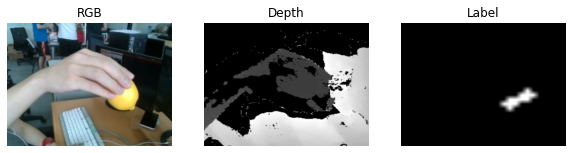

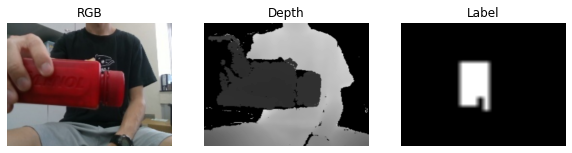

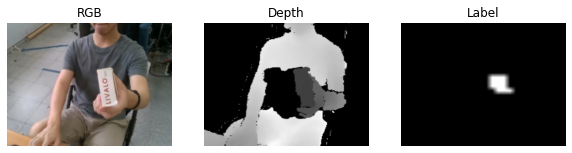

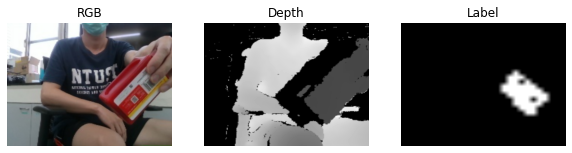

In [7]:
for _ in range(4):
    # Get smaple data
    batch = next(iter(dataloader))
    # RGB and Depth image
    color = batch['color_origin'][0].numpy()
    depth = batch['depth_origin'][0].numpy()

    # object angle id and label
    idx = batch['id'][0].numpy()
    label = batch['label'][0].permute(2,0,1).numpy()[:,:,idx]
    label = cv2.resize(label, (640,480))
    
    # Visualize
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 3, 1)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(color)

    fig.add_subplot(1, 3, 2)
    plt.axis('off')
    plt.title('Depth')
    plt.imshow(depth, cmap='gray')

    fig.add_subplot(1, 3, 3)
    plt.axis('off')
    plt.title('Label')
    plt.imshow(label, cmap='gray')

## B. Import simple testing datasets of HANet

## Visualize HANet Easy Testing Datasets (3b)
Data num : 200

Image size : RGB (224x224x3) / Depth (224x224)

senario: An object held by 1 of 3 sitting people at the desk or a laying person at the patient bed

Source: 
1. RGB-D images taken by the camera front of the bed

### Load data

In [9]:
from handover_grasping.Datavisualizer import rosenberger_dataloader
hanet_easy_loader = rosenberger_dataloader('/home/arg/handover_grasping/data/HANet_easy_datasets')

### Plot  the data

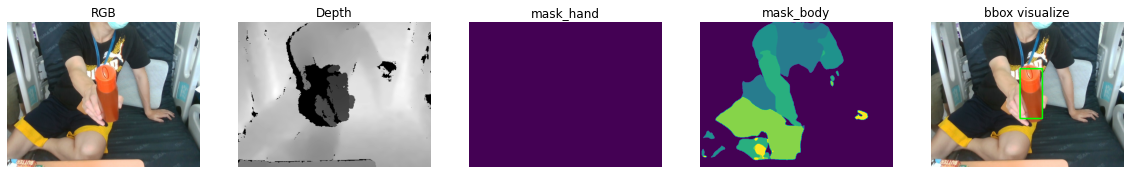

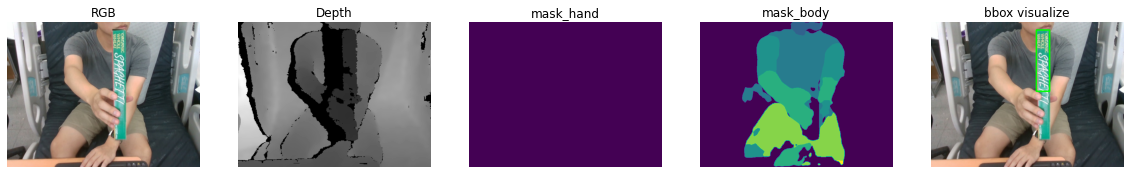

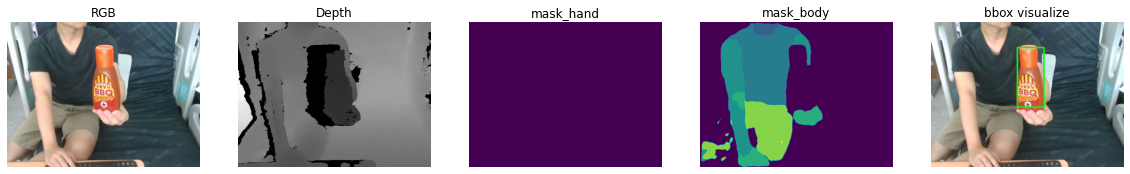

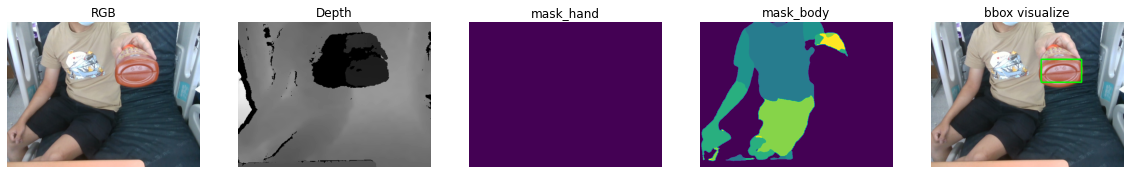

In [10]:
for _ in range(4):
    # Get sample data
    batch = hanet_easy_loader.get_next_data(vis_bbox=True)
    color = batch['color']
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    color_bbox = batch['color_bbox']
    depth = batch['depth']
    mask_hand = batch['mask_hand']
    mask_body = batch['mask_body']
    bbox = batch['bbox']
    
    # Visualize
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 5, 1)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(color)

    fig.add_subplot(1, 5, 2)
    plt.axis('off')
    plt.title('Depth')
    plt.imshow(depth, cmap='gray')

    fig.add_subplot(1, 5, 3)
    plt.axis('off')
    plt.title('mask_hand')
    plt.imshow(mask_hand)

    fig.add_subplot(1, 5, 4)
    plt.axis('off')
    plt.title('mask_body')
    plt.imshow(mask_body)

    fig.add_subplot(1, 5, 5)
    plt.axis('off')
    plt.title('bbox visualize')
    plt.imshow(color_bbox)
    
    plt.show()

## C. Import testing datasets of HANet

## Visualize HANet Testing Datasets (3b)
Data num : 240

Image size : RGB (224x224x3) / Depth (224x224)

senario: An object hold by a laying person
in the patient bed

Source: 
1. RGB-D images taken by the camera front of the bed

### Load data

In [2]:
from torch.utils.data import  DataLoader
from matplotlib import pyplot as plt
import cv2
from handover_grasping.Datavisualizer import handover_grasping_dataset

# loal data
DATA_PATH = '/home/arg/handover_grasping/data/HANet_testing'

dataset = handover_grasping_dataset(DATA_PATH, mode='test')
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 8)

### Plot  the data

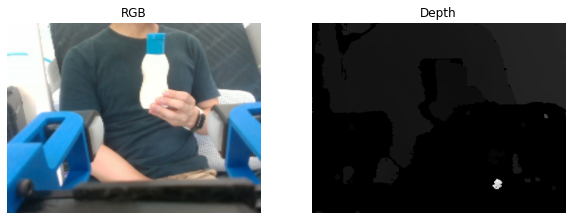

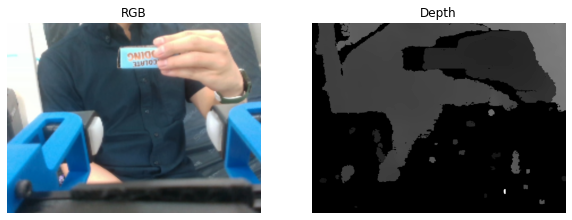

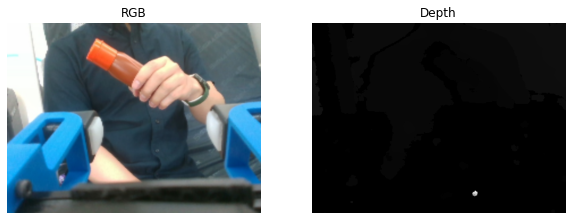

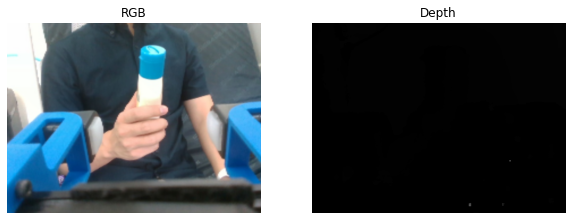

In [3]:
for _ in range(4):
    # Get smaple data
    batch = next(iter(dataloader))
    # RGB and Depth image
    color = batch['color_origin'][0].numpy()
    depth = batch['depth_origin'][0].numpy()
    
    # Visualize
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(color)

    fig.add_subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Depth')
    plt.imshow(depth, cmap='gray')

## D. Import testing datasets of ConvNet

## Visualize testing dataset of ConvNet

ref:https://github.com/andyzeng/arc-robot-vision

This dataloader will load image and rotate 16 time from 0 to 337.5 degrees

### Load data

In [12]:
import cv2
from torch.utils.data import  DataLoader
from matplotlib import pyplot as plt
from handover_grasping.Datavisualizer import parallel_jaw_based_grasping_dataset
from handover_grasping.utils import Image_table

dataset = parallel_jaw_based_grasping_dataset('/home/arg/handover_grasping/data/parallel-jaw-grasping-dataset', use_zeng=True)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 1)

batch = next(iter(dataloader))

# RGB and Depth image list, each contain 16 images
colors = batch['color_origin']
depths = batch['depth_origin']

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Plot data
1. RGB

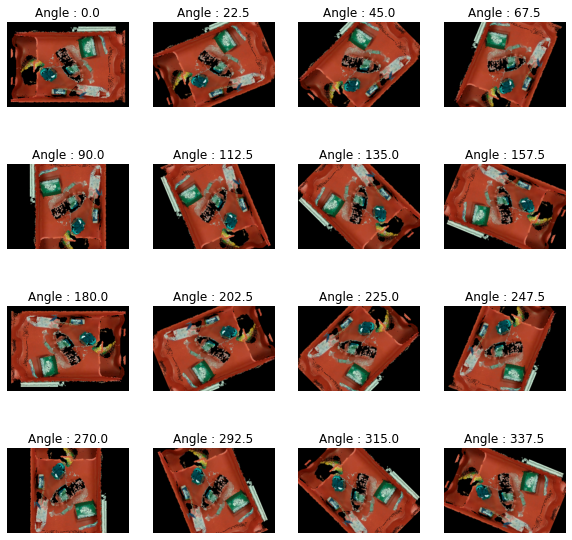

In [13]:
color_list = []
title_list = []
for i in range(len(colors)):
    color_sub = colors[i][0].numpy()
    color_list.append(color_sub[:,:,[2,1,0]])
    title_list.append('Angle : '+str(i*22.5))
    
Image_table(4, 4, color_list, title_list)

2. Depth

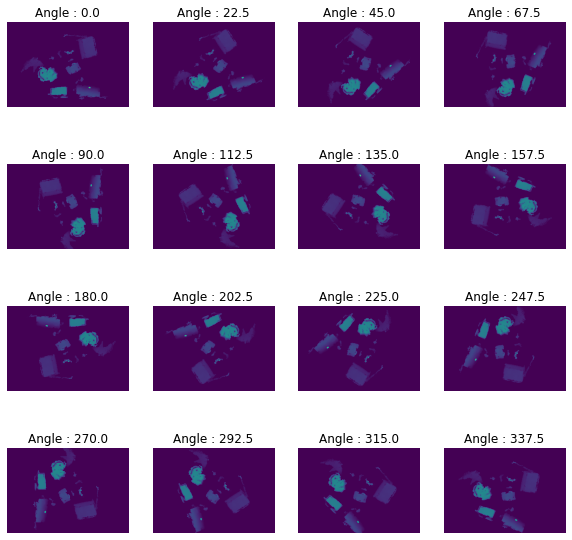

In [14]:
depth_list = []
for i in range(len(depths)):
    depth_sub = depths[i][0].numpy()
    depth_list.append(depth_sub)
    
Image_table(4, 4, depth_list, title_list)

## E. Import testing datasets of DOPE

## Visualize DOPE Testing datasets
Data num : 92

Image size : RGB (224x224x3) / Depth (224x224)

senario: Several objects stacked on the table

Source: 

Using clip images of YCB-Video, include RGB-D images 

ref:https://github.com/yuxng/PoseCNN

### Load data

In [15]:
from handover_grasping.Datavisualizer import rosenberger_dataloader
import cv2
from matplotlib import pyplot as plt

hanet_easy_loader = rosenberger_dataloader('/home/arg/handover_grasping/data/Dope_testing', color_type='png',depth_type='png')

### Visualize

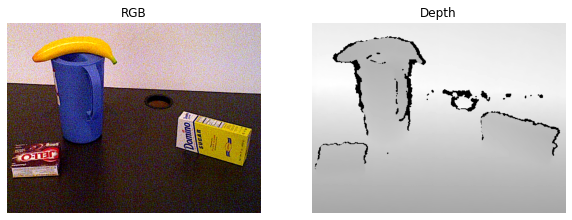

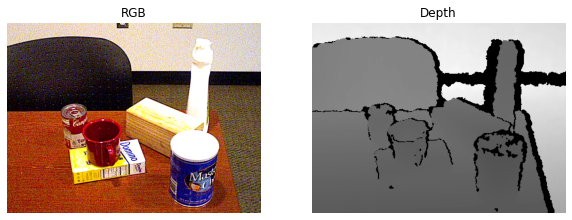

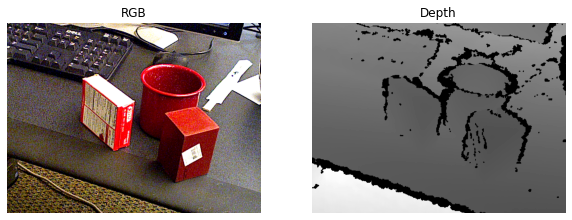

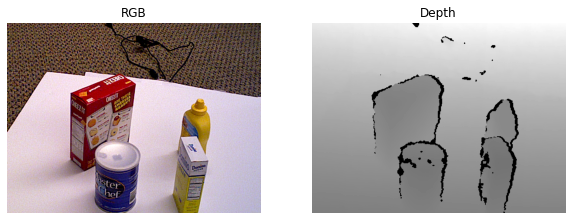

In [16]:
for _ in range(4):
    # Get sample data
    batch = hanet_easy_loader.get_next_data()
    color = batch['color']
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    depth = batch['depth']
    
    # Visualize
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.axis('off')
    plt.title('RGB')
    plt.imshow(color)

    fig.add_subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Depth')
    plt.imshow(depth, cmap='gray')
    
    plt.show()